# 🏴‍☠️ Pirate Pain Classification Challenge

> ⚓ *"Even pirates feel pain — let's teach the model to feel it too."*

---

## 📚 Table of Contents
0. [README](#readme)  
1. [Setup & Configuration](#setup)  
2. [Data Loading](#data-loading)  
3. [Import Libraries](#import-libraries)  
4. [Data Preprocessing](#data-preprocessing)  
5. [Sequence Building](#sequence-building)  
6. [DataLoaders](#dataloaders)  
7. [Network Hyperparameters](#hyperparameters)
8. [Model Architecture](#model-architecture)  
9. [Training Functions](#training-functions)  
10. [Model Training](#model-training)  
11. [Evaluation & Metrics](#evaluation)  
12. [Model Loading & Final Testing](#model-loading)  
13. [Competition Submission](#submission)

---

### ⚙️ Quick Configuration Map

> 🧭 *"If ye seek to tweak the code, here be where to look!"*

- 🧺 **Batch Size:** → [DataLoaders](#dataloaders)  
- ⚗️ **Hyperparameters:** → [Network Hyperparameters](#hyperparameters)  
- 🪞 **Window Size & Stride:** → [Sequence Building](#sequence-building)  
- ⚙️ **Model Type:** → [Setup & Configuration](#setup)  

---



---

### 💰 Treasure Storage — Models & Submissions
> 🏴‍☠️ *"A wise pirate always knows where his treasure be buried — guard yer models and submissions well!"*

- 💾 **Model & Submission Save/Load Path:** → [Setup & Configuration](#setup)  
  - 🗂️ Models be saved in a **`models/`** folder with the name:
    **`experiment_name_dd-mm-HH-MM.pt`** (day-month-hour-minute).
  - 📜 Submissions be saved in a **`submissions/`** folder with the filename format:  
    **`experiment_name_dd-mm-HH-MM.csv`** .
  - 🔡 All related model parameters are saved in **`models/`** folder with the  name **`experiment_name_dd-mm-HH-MM_config.json`** .

  
  *❗The experiment name is set as **`RnnType_Bi_dd-mm-HH-MM`** or **`RnnType_dd-mm-HH-MM`** depending on if it is bidirectional or not*
---






<a id="readme"></a>
## 0. Info



This section lists all the main parameters that can be modified to control data loading, model behavior, and training.

---

### 📁 File Paths
| Variable | Description | Default Value |
|-----------|--------------|----------------|
| `TRAIN_DATA_PATH` | Training features | `'pirate_pain_train.csv'` |
| `TRAIN_LABELS_PATH` | Training labels | `'pirate_pain_train_labels.csv'` |
| `TEST_DATA_PATH` | Test set for inference | `'pirate_pain_test.csv'` *(optional)* |
| `MODEL_SAVE_PATH` | Output model file | `'pirate_model.pt'` |
| `RESULTS_FILE` | CSV for predictions | `'results_<date-time>.csv'` |

---

### 🧠 Model & Architecture
| Parameter | Description | Typical Values |
|------------|--------------|----------------|
| `model_type` | Choose model class | `'RNN'`, `'LSTM'`, `'GRU'`, `'ANN'` |
| `input_size` | Number of features per time step | *auto-detected from data* |
| `hidden_size` | Hidden layer size | `64`, `128`, `256` |
| `num_layers` | Number of RNN layers | `1-4` |
| `dropout` | Dropout probability | `0.2–0.5` |
| `num_classes` | Output classes (pain levels) | *from label set* |

---

### 🏋️ Training Hyperparameters
| Parameter | Description | Default / Range |
|------------|--------------|-----------------|
| `batch_size` | Samples per batch | `512/2^n` |
| `learning_rate` | Optimizer learning rate | `1e-3` |
| `num_epochs` | Training iterations | `500` |
| `optimizer` | Optimization algorithm | `'AdamW'` |
| `criterion` | Loss function | `CrossEntropyLoss()` |
| `seed` | Random seed for reproducibility | `42` |

---

### 📤 Inference
| Parameter | Description |
|------------|--------------|
| `LOAD_MODEL_PATH` | Path to pretrained `.pt` model (optional) |
| `save_results` | Whether to write output CSV | `True` |

---

> 💡 *Tip:* Adjust hyperparameters in the “Configuration” or “Training Setup” cell before running the notebook.


<a id="setup"></a>
## 1. Setup & Configuration

*Optional: Connect to Google Drive (for Colab users)*

In [590]:
from google.colab import drive
drive.mount("/gdrive")
current_dir = "/gdrive/MyDrive/pirate_dataset"
%cd $current_dir

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/pirate_dataset


*Set Model Type*

In [591]:
RNN_TYPE = 'LSTM'            # 'RNN', 'LSTM', or 'GRU'
BIDIRECTIONAL = True        # True / False

*Set Model Save Name*

In [592]:
from datetime import datetime

# Get current date and time for submission filename
current_datetime = datetime.now().strftime("%d-%m-%H-%M")

if BIDIRECTIONAL:
    EXPERIMENT_NAME = f"{RNN_TYPE}_bi_{current_datetime}"
else:
    EXPERIMENT_NAME = f"{RNN_TYPE}_{current_datetime}"

SUBMISSION_FILENAME = f"{EXPERIMENT_NAME}.csv"


# Directory configuration
logs_dir = "tensorboard"
models_dir = "models"

# Model save/load paths
MODEL_SAVE_PATH = f"{models_dir}/{EXPERIMENT_NAME}_model.pt"
MODEL_LOAD_PATH = f"{models_dir}/{EXPERIMENT_NAME}_model.pt"




print(f"Experiment name: {EXPERIMENT_NAME}")
print(f"Submission filename: {SUBMISSION_FILENAME}")
print(f"Model save path: {MODEL_SAVE_PATH}")
print(f"Model load path: {MODEL_LOAD_PATH}")

Experiment name: LSTM_bi_10-11-23-52
Submission filename: LSTM_bi_10-11-23-52.csv
Model save path: models/LSTM_bi_10-11-23-52_model.pt
Model load path: models/LSTM_bi_10-11-23-52_model.pt


<a id="data-loading"></a>
## 2. Data Loading

Load training and test datasets from CSV files.

In [593]:
import pandas as pd

X_train = pd.read_csv('pirate_pain_train.csv')
y_train = pd.read_csv('pirate_pain_train_labels.csv')

<a id="import-libraries"></a>
## 3. Import Libraries

Set random seeds for reproducibility and import all necessary packages.

In [594]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
from collections import Counter






!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p {models_dir}

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from datetime import datetime
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
PyTorch version: 2.8.0+cu126
Device: cuda


<a id="data-preprocessing"></a>
## 4. Data Preprocessing

Explore data, split into train/val/test sets, normalize features, and encode labels.

### 4.1 Data Exploration

In [595]:
# Print the shape of the dataset
print(f"Dataset shape: {X_train.shape}")

# Display the first few rows of the dataset
X_train.head(10)

Dataset shape: (105760, 40)


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
0,0,0,2,0,2,1,two,two,two,1.094705,...,3.499558e-06,1.945042e-06,3.999558e-06,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5
1,0,1,2,2,2,2,two,two,two,1.135183,...,3.976952e-07,6.765107e-07,6.019627e-06,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5
2,0,2,2,0,2,2,two,two,two,1.080745,...,1.533820e-07,1.698525e-07,1.446051e-06,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5
3,0,3,2,2,2,2,two,two,two,0.938017,...,1.006865e-05,5.511079e-07,1.847597e-06,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5
4,0,4,2,2,2,2,two,two,two,1.090185,...,4.437266e-06,1.735459e-07,1.552722e-06,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5
5,0,5,2,0,2,1,two,two,two,1.146031,...,1.073167e-06,1.753837e-07,2.957340e-07,6.217311e-08,0.000007,0.006150,0.006444,0.033101,0.023767,0.5
6,0,6,2,1,2,1,two,two,two,1.025870,...,1.074800e-06,1.772156e-07,1.976558e-06,1.576086e-06,0.000005,0.006495,0.006421,0.031804,0.019056,0.5
7,0,7,2,2,2,2,two,two,two,1.038597,...,8.829074e-07,1.790415e-07,2.210562e-06,1.485741e-06,0.000000,0.015998,0.005397,0.035552,0.015732,0.5
8,0,8,2,2,0,1,two,two,two,0.984251,...,1.621055e-06,1.165161e-06,3.030164e-07,5.416678e-07,0.000000,0.020539,0.008517,0.008635,0.015257,0.5
9,0,9,0,2,2,2,two,two,two,1.054999,...,1.609114e-06,3.959558e-06,2.017157e-06,1.154349e-06,0.000007,0.007682,0.021383,0.034006,0.028966,0.5


### 4.2 Categorical Encoding

In [596]:
# Merge features and labels
data = X_train.merge(y_train, on='sample_index')

# Create a mapping dictionary to convert categorical labels to numerical values
map_dict = {'none': 0, 'one': 1, 'two': 2}
data['n_legs'] = data['n_legs'].map(map_dict)
data['n_hands'] = data['n_hands'].map(map_dict)
data['n_eyes'] = data['n_eyes'].map(map_dict)


### 4.3 Stratified Train/Val/Test Split

In [597]:
import pandas as pd
import random
from sklearn.model_selection import train_test_split

# df has columns: ['sample_index', 'label']
N_VAL_USERS = 40
N_TEST_USERS = 20

# --- Step 1: Compute each user's dominant label (or label distribution)
user_labels = (
    data.groupby('sample_index')['label']
    .agg(lambda x: x.value_counts().index[0])  # dominant label per user
    .reset_index()
)

train_users, temp_users = train_test_split(
    user_labels['sample_index'],
    test_size=(N_VAL_USERS + N_TEST_USERS) / len(user_labels),
    stratify=user_labels['label'],
    random_state=SEED
)

# Split temp into val/test (also stratified)
temp_labels = user_labels[user_labels['sample_index'].isin(temp_users)]
if N_TEST_USERS != 0:
  val_users, test_users = train_test_split(
      temp_labels['sample_index'],
      test_size=N_TEST_USERS / (N_VAL_USERS + N_TEST_USERS),
      stratify=temp_labels['label'],
      random_state=SEED
  )
else:
  val_users = temp_users
  test_users = []

# --- Step 3: Filter your main df
df_train = data[data['sample_index'].isin(train_users)]
df_val = data[data['sample_index'].isin(val_users)]
df_test = data[data['sample_index'].isin(test_users)]

# --- Step 4: Check label proportions
print("Label proportions:")
print("Train:\n", df_train['label'].value_counts(normalize=True))
print("Val:\n", df_val['label'].value_counts(normalize=True))
print("Test:\n", df_test['label'].value_counts(normalize=True))

Label proportions:
Train:
 label
no_pain      0.773710
low_pain     0.141431
high_pain    0.084859
Name: proportion, dtype: float64
Val:
 label
no_pain      0.766667
low_pain     0.166667
high_pain    0.066667
Name: proportion, dtype: float64
Test:
 label
no_pain      0.766667
low_pain     0.133333
high_pain    0.100000
Name: proportion, dtype: float64


In [598]:
df_train.shape, df_val.shape, df_test.shape

((96160, 41), (4800, 41), (4800, 41))

In [599]:
# Print the total number of pirates for each dataset
print(f"Total pirates in training set: {df_train['sample_index'].nunique()}")
print(f"Total pirates in validation set: {df_val['sample_index'].nunique()}")
print(f"Total pirates in test set: {df_test['sample_index'].nunique()}")

Total pirates in training set: 601
Total pirates in validation set: 30
Total pirates in test set: 30


### 4.4 Feature Normalization (min-max)

In [600]:
# Define the columns to be normalised

scale_columns = [col for col in data.columns
                 if (col.startswith('joint_') or col.startswith('pain_survey')) and not col.startswith('joint_30')]



# Calculate the minimum and maximum values from the training data only
mins_train = df_train[scale_columns].min()
maxs_train = df_train[scale_columns].max()

#mins_val = df_val[scale_columns].min()
#maxs_val = df_val[scale_columns].max()
#
#mins_test = df_test[scale_columns].min()
#maxs_test = df_test[scale_columns].max()

####
#CHANGED ALL THE REGULARIZATION TO USE MIN AND MAX VALUES FROM THE TRAINING DATA FOR GENERALIZATION
###

# Apply normalisation to the specified columns in all datasets
for column in scale_columns:
    # Normalise the training set
    df_train[column] = (df_train[column] - mins_train[column]) / (maxs_train[column] - mins_train[column])

    # Normalise the validation set
    df_val[column] = (df_val[column] - mins_train[column]) / (maxs_train[column] - mins_train[column])

    # Normalise the test set
    df_test[column] = (df_test[column] - mins_train[column]) / (maxs_train[column] - mins_train[column])


In [601]:
df_train.head()

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30,label
0,0,0,1.0,0.0,1.0,0.5,2.0,2.0,2.0,0.777507,...,1.374706e-06,0.000015,3.162813e-04,0.000004,0.014214,0.011376,0.018978,0.020291,0.5,no_pain
1,0,1,1.0,1.0,1.0,1.0,2.0,2.0,2.0,0.806256,...,4.026521e-07,0.000022,9.828599e-07,0.000000,0.010748,0.000000,0.009473,0.010006,0.5,no_pain
2,0,2,1.0,0.0,1.0,1.0,2.0,2.0,2.0,0.767592,...,1.440847e-08,0.000005,6.626013e-05,0.000003,0.013097,0.006830,0.017065,0.016856,0.5,no_pain
3,0,3,1.0,1.0,1.0,1.0,2.0,2.0,2.0,0.666220,...,3.065580e-07,0.000007,1.199337e-06,0.000000,0.009505,0.006274,0.020264,0.017981,0.5,no_pain
4,0,4,1.0,1.0,1.0,1.0,2.0,2.0,2.0,0.774297,...,1.723863e-08,0.000006,1.307199e-06,0.000007,0.004216,0.002132,0.023389,0.018477,0.5,no_pain


### 4.5 Label Distribution Analysis

In [602]:
# Initialise a dictionary to count occurrences of each activity in the training set
training_labels = {
    'no_pain': 0,
    'low_pain': 0,
    'high_pain': 0
}

# Count occurrences of each activity for unique IDs in the training set
for id in df_train['sample_index'].unique():
    label = df_train[df_train['sample_index'] == id]['label'].values[0]
    training_labels[label] += 1


# Print the distribution of training labels
print('Training labels:', training_labels)

# Initialise a dictionary to count occurrences of each activity in the training set
val_labels = {
    'no_pain': 0,
    'low_pain': 0,
    'high_pain': 0
}

# Count occurrences of each activity for unique IDs in the training set
for id in df_val['sample_index'].unique():
    label = df_val[df_val['sample_index'] == id]['label'].values[0]
    val_labels[label] += 1

# Print the distribution of validation labels
print('Validation labels:', val_labels)

# Initialise a dictionary to count occurrences of each activity in the test set
test_labels = {
    'no_pain': 0,
    'low_pain': 0,
    'high_pain': 0
}

# Count occurrences of each activity for unique IDs in the test set
for id in df_test['sample_index'].unique():
    label = df_test[df_test['sample_index'] == id]['label'].values[0]
    test_labels[label] += 1

# Print the distribution of test labels
print('Test labels:', test_labels)

Training labels: {'no_pain': 465, 'low_pain': 85, 'high_pain': 51}
Validation labels: {'no_pain': 23, 'low_pain': 5, 'high_pain': 2}
Test labels: {'no_pain': 23, 'low_pain': 4, 'high_pain': 3}


In [603]:
# Define a training mapping of label names to integer labels
label_mapping = {
    'no_pain': 0,
    'low_pain': 1,
    'high_pain': 2
}

# Map label names to integers in the training set
df_train['label'] = df_train['label'].map(label_mapping)

# Map label names to integers in the validation set
df_val['label'] = df_val['label'].map(label_mapping)

# Map label names to integers in the test set
df_test['label'] = df_test['label'].map(label_mapping)


<a id="sequence-building"></a>
## 5. Sequence Building

Convert variable-length time-series into fixed-size windows for RNN input.

In [604]:

# Define window and stride boolean variable -> if True, during training we will visit more time the same pirate with overlapping windows
# if False, each pirate will be visited only once during training
one_pirate_window = True

In [605]:
if one_pirate_window:
    # Define the window size
    WINDOW_SIZE = 40 # before: 80

    # Stride size
    STRIDE = 5
else:
    # Define the window size -> select an higher window size in order to get more pirates
    WINDOW_SIZE = 160

    # Stride size
    STRIDE = 160

### 5.1 Window & Stride Configuration

### 5.2 Build Sequences Function

In [606]:
"""
  GENERAL COMMENTS:
  in this function we are restricting for each user data the number of samples of recorded data to a constant
  value (window size), since every user data could be composed by different numbers of timestep. Therefore we are
  "normalizing" the timesteps of a constant window size. Additionally is also defined a stride variable, which if is equal to
  the window size, then we are not taking overlapping timestamp samples, instead if stride < window, we are letting some samples
  to overlap in such a way that the RNN or other kind of NN architecture will analyze better the context.
"""

# Define a function to build sequences from the dataset
def build_sequences(df, window=200, stride=200):
    # Sanity check to ensure the window is divisible by the stride
    assert window % stride == 0 # checks if the window size is divisible by the stride

    # Initialise lists to store sequences and their corresponding labels
    dataset = []
    labels = []

    # Iterate over unique IDs in the DataFrame
    for id in df['sample_index'].unique():

        # Extract pirate sample index data for the current sample index
        columns = [col for col in df.columns if col not in ['sample_index', 'label', 'time']]

        temp = df[df['sample_index'] == id][columns].values

        # Retrieve the label for the current pirate
        label = df[df['sample_index'] == id]['label'].values[0]

        # Calculate padding length to ensure full windows
        padding_len = window - len(temp) % window

        # Create zero padding and concatenate with the data
        padding = np.zeros((padding_len, len(columns)), dtype='float32')
        temp = np.concatenate((temp, padding))

        # Build feature windows and associate them with labels
        idx = 0
        while idx + window <= len(temp):
            dataset.append(temp[idx:idx + window])
            labels.append(label)
            idx += stride

    # Convert lists to numpy arrays for further processing
    dataset = np.array(dataset)
    labels = np.array(labels)

    return dataset, labels

### 5.3 Generate Sequences for Train/Val/Test

In [607]:
# Generate sequences and labels for the training set
X_train, y_train = build_sequences(df_train, WINDOW_SIZE, STRIDE)

# Generate sequences and labels for the validation set
X_val, y_val = build_sequences(df_val, WINDOW_SIZE, STRIDE)

# Generate sequences and labels for the test set
X_test, y_test = build_sequences(df_test, WINDOW_SIZE, STRIDE)

# Print the shapes of the generated datasets and their labels
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (19833, 40, 38), y_train shape: (19833,)
X_val shape: (990, 40, 38), y_val shape: (990,)
X_test shape: (990, 40, 38), y_test shape: (990,)


### 5.4 Data Type Conversion & Cleaning

In [608]:
# Convert dataset into float32 for PyTorch compatibility
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')
# y_train = y_train.astype('int64')
# y_val = y_val.astype('int64')
# y_test = y_test.astype('int64')

In [609]:
# Define the input shape based on the training data
input_shape = X_train.shape[1:]

# Define the number of classes based on the categorical labels
num_classes = len(np.unique(y_train))
print(f"Number of Classes: {num_classes}")

Number of Classes: 3


In [610]:

# Discard nan values from the dataset
if np.isnan(X_train).any() or np.isnan(X_val).any() or np.isnan(X_test).any():
    X_train = np.nan_to_num(X_train)
    X_val = np.nan_to_num(X_val)
    X_test = np.nan_to_num(X_test)


In [611]:
# Convert numpy arrays to PyTorch datasets (pairs features with labels)
train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_ds   = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_ds  = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

<a id="dataloaders"></a>
## 6. DataLoaders

Create PyTorch DataLoaders for efficient batching and parallel loading.

In [612]:
# Define the batch size, which is the number of samples in each batch
BATCH_SIZE = 512 # we can change it depending on the GPU RAM available (by default 512)

In [613]:
def make_loader(ds, batch_size, shuffle, drop_last):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

In [614]:
# Create data loaders with different settings for each phase
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [615]:
# Get one batch from the training data loader
for xb, yb in train_loader:
    print("Features batch shape:", xb.shape)
    print("Labels batch shape:", yb.shape)
    break # Stop after getting one batch

Features batch shape: torch.Size([512, 40, 38])
Labels batch shape: torch.Size([512])


In [616]:
def recurrent_summary(model, input_size):
    """
    Custom summary function that emulates torchinfo's output while correctly
    counting parameters for RNN/GRU/LSTM layers.

    This function is designed for models whose direct children are
    nn.Linear, nn.RNN, nn.GRU, or nn.LSTM layers.

    Args:
        model (nn.Module): The model to analyze.
        input_size (tuple): Shape of the input tensor (e.g., (seq_len, features)).
    """

    # Dictionary to store output shapes captured by forward hooks
    output_shapes = {}
    # List to track hook handles for later removal
    hooks = []

    def get_hook(name):
        """Factory function to create a forward hook for a specific module."""
        def hook(module, input, output):
            # Handle RNN layer outputs (returns a tuple)
            if isinstance(output, tuple):
                # output[0]: all hidden states with shape (batch, seq_len, hidden*directions)
                shape1 = list(output[0].shape)
                shape1[0] = -1  # Replace batch dimension with -1

                # output[1]: final hidden state h_n (or tuple (h_n, c_n) for LSTM)
                if isinstance(output[1], tuple):  # LSTM case: (h_n, c_n)
                    shape2 = list(output[1][0].shape)  # Extract h_n only
                else:  # RNN/GRU case: h_n only
                    shape2 = list(output[1].shape)

                # Replace batch dimension (middle position) with -1
                shape2[1] = -1

                output_shapes[name] = f"[{shape1}, {shape2}]"

            # Handle standard layer outputs (e.g., Linear)
            else:
                shape = list(output.shape)
                shape[0] = -1  # Replace batch dimension with -1
                output_shapes[name] = f"{shape}"
        return hook

    # 1. Determine the device where model parameters reside
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu")  # Fallback for models without parameters

    # 2. Create a dummy input tensor with batch_size=1
    dummy_input = torch.randn(1, *input_size).to(device)

    # 3. Register forward hooks on target layers
    # Iterate through direct children of the model (e.g., self.rnn, self.classifier)
    for name, module in model.named_children():
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM)):
            # Register the hook and store its handle for cleanup
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    # 4. Execute a dummy forward pass in evaluation mode
    model.eval()
    with torch.no_grad():
        try:
            model(dummy_input)
        except Exception as e:
            print(f"Error during dummy forward pass: {e}")
            # Clean up hooks even if an error occurs
            for h in hooks:
                h.remove()
            return

    # 5. Remove all registered hooks
    for h in hooks:
        h.remove()

    # --- 6. Print the summary table ---

    print("-" * 79)
    # Column headers
    print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)

    total_params = 0
    total_trainable_params = 0

    # Iterate through modules again to collect and display parameter information
    for name, module in model.named_children():
        if name in output_shapes:
            # Count total and trainable parameters for this module
            module_params = sum(p.numel() for p in module.parameters())
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

            total_params += module_params
            total_trainable_params += trainable_params

            # Format strings for display
            layer_name = f"{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"

            print(f"{layer_name:<25} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)

<a id="hyperparameters"></a>
## 7. Network Hyperparameters

Configure training settings, architecture parameters, and regularization.

In [617]:
 # Training configuration
LEARNING_RATE = 1e-3
EPOCHS = 500
PATIENCE = 40

# Architecture
HIDDEN_LAYERS = 2        # Hidden layers
HIDDEN_SIZE = 64        # Neurons per layer -> prev hidden size = 128

# Regularisation
DROPOUT_RATE = 0.3     # Dropout probability

# For now disable weight decay
L1_LAMBDA = 0.0001         # L1 penalty
L2_LAMBDA = 0.001             # L2 penalty

# Set up loss function and optimizer
weights = torch.tensor([0.5, 1.0, 1.2]).to(device)# Not used

criterion = nn.CrossEntropyLoss(weight=None)

In [618]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

<a id="model-architecture"></a>
## 8. Model Architecture

Custom RNN/LSTM/GRU classifier with configurable bidirectionality and dropout.

### 7.1 Recurrent Classifier Class

In [619]:
class RecurrentClassifier(nn.Module):
    """
    Generic RNN classifier (RNN, LSTM, GRU).
    Uses the last hidden state for classification.
    """
    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers,
            num_classes,
            rnn_type= RNN_TYPE,        # 'RNN', 'LSTM', or 'GRU'
            bidirectional=BIDIRECTIONAL,
            dropout_rate=0.2
            ):
        super().__init__()

        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        # Map string name to PyTorch RNN class
        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }

        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")

        rnn_module = rnn_map[rnn_type]

        # Dropout is only applied between layers (if num_layers > 1)
        dropout_val = dropout_rate if num_layers > 1 else 0 # dropout between RNN layers, applied for regularization

        # Create the recurrent layer
        self.rnn = rnn_module(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,       # Input shape: (batch, seq_len, features)
            bidirectional=bidirectional, # We are defining a bidirectional RNN since we want to extract also the future contextual information for making better predictions
            dropout=dropout_val
        )

        # Calculate input size for the final classifier
        if self.bidirectional:
            classifier_input_size = hidden_size * 2 # Concat fwd + bwd
        else:
            classifier_input_size = hidden_size

        # Final classification layer
        self.classifier = nn.Linear(classifier_input_size, num_classes) # output layer for classifying

    def forward(self, x):
        """
        x shape: (batch_size, seq_length, input_size)
        """

        # rnn_out shape: (batch_size, seq_len, hidden_size * num_directions)
        rnn_out, hidden = self.rnn(x) # feeds the input sequence into the RNN layer
        # rnn_out -> contains the hidden state output for every timestep

        # LSTM returns (h_n, c_n), we only need h_n
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]  # final hidden state of the last timestep

        # hidden shape: (num_layers * num_directions, batch_size, hidden_size)

        if self.bidirectional:
            # Reshape to (num_layers, 2, batch_size, hidden_size)
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)

            # Concat last fwd (hidden[-1, 0, ...]) and bwd (hidden[-1, 1, ...])
            # Final shape: (batch_size, hidden_size * 2)
            hidden_to_classify = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1)
        else:
            # Take the last layer's hidden state
            # Final shape: (batch_size, hidden_size)
            hidden_to_classify = hidden[-1]

        # Get logits
        logits = self.classifier(hidden_to_classify)
        return logits

<a id="training-functions"></a>
## 9. Training Functions

Helper functions for training, validation, logging, and early stopping.

In [620]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

### 9.1 Train One Epoch Function

In [621]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

### 9.2 Validate One Epoch Function

In [622]:
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty before adding a histogram
            if param.numel() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty before adding a histogram
                if param.grad.numel() > 0:
                    if param.grad is not None and torch.isfinite(param.grad).all():
                        writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

### 9.3 Fit  Function

In [623]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), MODEL_SAVE_PATH)
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load(MODEL_SAVE_PATH))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), MODEL_SAVE_PATH)

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

### 9.4 Training Loop

In [624]:
%%time

# Create model and display architecture with parameter count
rnn_model = RecurrentClassifier(
    input_size=input_shape[-1], # Pass the number of features
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    bidirectional=BIDIRECTIONAL,
    rnn_type=RNN_TYPE
    ).to(device)
recurrent_summary(rnn_model, input_size=input_shape)

# Set up TensorBoard logging and save model architecture
writer = SummaryWriter(f"./{logs_dir}/{EXPERIMENT_NAME}")
x = torch.randn(1, input_shape[0], input_shape[1]).to(device)
writer.add_graph(rnn_model, x)

# Define optimizer with L2 regularization
optimizer = torch.optim.AdamW(rnn_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

# Train model and track training history
rnn_model, training_history = fit(
    model=rnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    l1_lambda=L1_LAMBDA,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=1,
    experiment_name=EXPERIMENT_NAME,
    patience=PATIENCE
    )

# Update best model if current performance is superior
if training_history['val_f1'][-1] > best_performance:
    best_model = rnn_model
    best_performance = training_history['val_f1'][-1]

-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (LSTM)                [[-1, 40, 128], [4, -1, 64]] 152,576        
classifier (Linear)       [-1, 3]                      387            
Total params: 152,963
Trainable params: 152,963
Non-trainable params: 0
-------------------------------------------------------------------------------
Training 500 epochs...
Epoch   1/500 | Train: Loss=1.5731, F1 Score=0.6636 | Val: Loss=0.6875, F1 Score=0.6654
Epoch   2/500 | Train: Loss=1.1812, F1 Score=0.6750 | Val: Loss=0.6854, F1 Score=0.6654
Epoch   3/500 | Train: Loss=0.9559, F1 Score=0.6750 | Val: Loss=0.6833, F1 Score=0.6654
Epoch   4/500 | Train: Loss=0.8148, F1 Score=0.6753 | Val: Loss=0.6396, F1 Score=0.6654
Epoch   5/500 | Train: Loss=0.7197, F1 Score=0.7247 | Val: Loss=0.6181, F1 Score=0.7625
Epoch   6/500 | Train: Loss=0.6754, F1 Score=0.7457 | Val: Loss=0.5770, F1 Score=0.7946
E

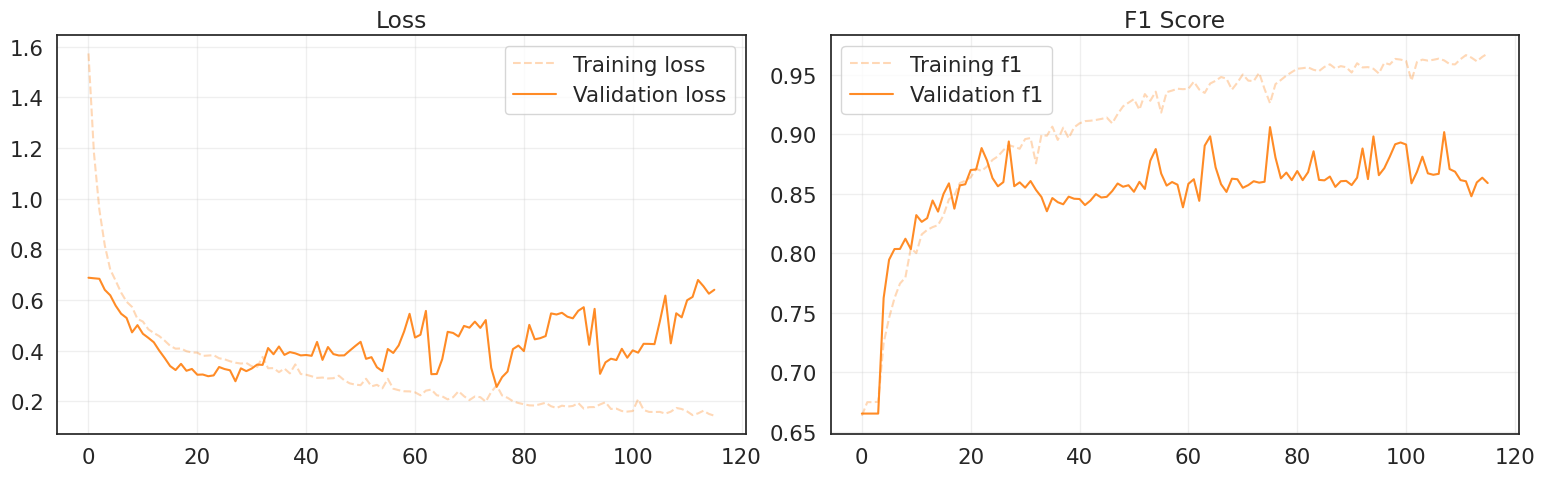

In [625]:
# @title Plot History
# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

Accuracy over the validation set: 0.9020
Precision over the validation set: 0.9114
Recall over the validation set: 0.9020
F1 score over the validation set: 0.9061


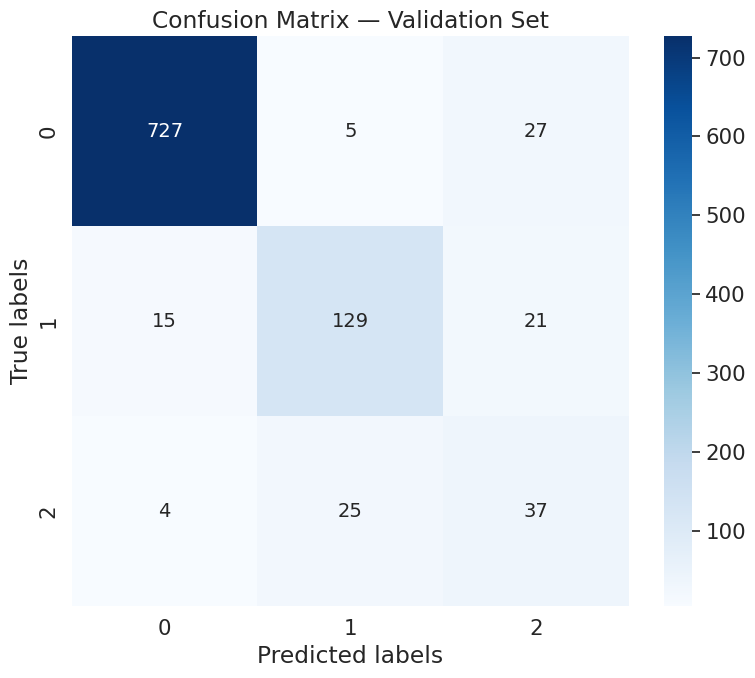

In [626]:
# @title Plot Confusion Matrix
# Collect predictions and ground truth labels
val_preds, val_targets = [], []
with torch.no_grad():  # Disable gradient computation for inference
    for xb, yb in val_loader:
        xb = xb.to(device)

        # Forward pass: get model predictions
        logits = rnn_model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()

        # Store batch results
        val_preds.append(preds)
        val_targets.append(yb.numpy())

# Combine all batches into single arrays
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Calculate overall validation metrics
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average='weighted')
val_rec = recall_score(val_targets, val_preds, average='weighted')
val_f1 = f1_score(val_targets, val_preds, average='weighted')
print(f"Accuracy over the validation set: {val_acc:.4f}")
print(f"Precision over the validation set: {val_prec:.4f}")
print(f"Recall over the validation set: {val_rec:.4f}")
print(f"F1 score over the validation set: {val_f1:.4f}")

# Generate confusion matrix for detailed error analysis
cm = confusion_matrix(val_targets, val_preds)

# Create numeric labels for heatmap annotation
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set')
plt.tight_layout()
plt.show()

<a id="evaluation"></a>
## 11. Evaluation & Metrics

Visualize training history and compute validation metrics.

In [627]:
rnn_model = RecurrentClassifier(
    input_size=input_shape[-1], # Pass the number of features
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    bidirectional=BIDIRECTIONAL,
    rnn_type=RNN_TYPE
    ).to(device)
print("Setting the model to evaluation mode...")
rnn_model.load_state_dict(torch.load(MODEL_LOAD_PATH, map_location=device))
rnn_model.eval()  # Set model to evaluation mode
recurrent_summary(rnn_model, input_size=input_shape)
print("\nStarting model evaluation on test set...")

# Verify data dimensions before inference
print(f"Model input size: {rnn_model.rnn.input_size}")
print(f"Test data feature size: {X_test.shape[-1]}")

test_preds, test_targets = [], []
test_probabilities = []
with torch.no_grad():  # Disable gradient computation for inference
    for xb, yb in test_loader:
        xb = xb.to(torch.float32)
        xb = xb.to(device)

        # Forward pass: get model predictions
        logits = best_model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()

        # Store batch results
        test_preds.append(preds)
        test_targets.append(yb.numpy())


# Combine all batches into single arrays
test_preds = np.concatenate(test_preds)
test_targets = np.concatenate(test_targets)

print(f"\nTest set evaluation completed successfully!")
print(f"Total test samples: {len(test_preds)}")
print(f"Predictions shape: {test_preds.shape}")
print(f"Targets shape: {test_targets.shape}")

Setting the model to evaluation mode...
-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (LSTM)                [[-1, 40, 128], [4, -1, 64]] 152,576        
classifier (Linear)       [-1, 3]                      387            
Total params: 152,963
Trainable params: 152,963
Non-trainable params: 0
-------------------------------------------------------------------------------

Starting model evaluation on test set...
Model input size: 38
Test data feature size: 38

Test set evaluation completed successfully!
Total test samples: 990
Predictions shape: (990,)
Targets shape: (990,)


<a id="model-loading"></a>
## 12. Model Loading & Final Testing

Load the trained model and evaluate on the internal test set.

### 12.1 Test Set Evaluation

### 12.2 Test Set Predictions

In [628]:
# --- Comprehensive Test Set Evaluation ---

# Calculate all evaluation metrics
test_accuracy = accuracy_score(test_targets, test_preds)
test_precision = precision_score(test_targets, test_preds, average='weighted')
test_recall = recall_score(test_targets, test_preds, average='weighted')
test_f1 = f1_score(test_targets, test_preds, average='weighted')

# Per-class metrics
test_precision_per_class = precision_score(test_targets, test_preds, average=None)
test_recall_per_class = recall_score(test_targets, test_preds, average=None)
test_f1_per_class = f1_score(test_targets, test_preds, average=None)

print("=" * 60)
print("               TEST SET EVALUATION RESULTS")
print("=" * 60)
print(f"Overall Test Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Overall Test Precision: {test_precision:.4f}")
print(f"Overall Test Recall:    {test_recall:.4f}")
print(f"Overall Test F1 Score:  {test_f1:.4f}")
print()

# Class names for better readability
class_names = ['No Pain', 'Low Pain', 'High Pain']

print("Per-Class Performance:")
print("-" * 40)
for i, class_name in enumerate(class_names):
    print(f"{class_name:>10}: Precision={test_precision_per_class[i]:.4f}, "
          f"Recall={test_recall_per_class[i]:.4f}, F1={test_f1_per_class[i]:.4f}")

print()

# Prediction distribution
unique_preds, pred_counts = np.unique(test_preds, return_counts=True)
unique_targets, target_counts = np.unique(test_targets, return_counts=True)

print("Prediction Distribution:")
print("-" * 25)
for i, class_name in enumerate(class_names):
    pred_count = pred_counts[i] if i in unique_preds else 0
    target_count = target_counts[i] if i in unique_targets else 0
    print(f"{class_name:>10}: Predicted={pred_count:3d}, Actual={target_count:3d}")

print("=" * 60)

               TEST SET EVALUATION RESULTS
Overall Test Accuracy:  0.8727 (87.27%)
Overall Test Precision: 0.8868
Overall Test Recall:    0.8727
Overall Test F1 Score:  0.8529

Per-Class Performance:
----------------------------------------
   No Pain: Precision=0.8615, Recall=1.0000, F1=0.9256
  Low Pain: Precision=1.0000, Recall=0.3939, F1=0.5652
 High Pain: Precision=0.9298, Recall=0.5354, F1=0.6795

Prediction Distribution:
-------------------------
   No Pain: Predicted=881, Actual=759
  Low Pain: Predicted= 52, Actual=132
 High Pain: Predicted= 57, Actual= 99


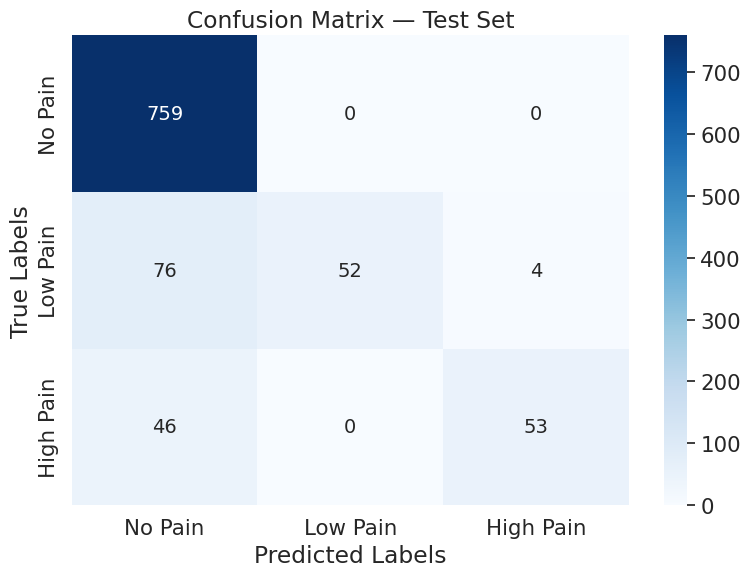

In [629]:
# --- Confusion Matrix (Test Set) ---

cm_test = confusion_matrix(test_targets, test_preds)

plt.figure(figsize=(8, 6))
labels = np.array([f"{num}" for num in cm_test.flatten()]).reshape(cm_test.shape)
sns.heatmap(cm_test, annot=labels, fmt='', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix — Test Set')
plt.tight_layout()
plt.show()


<a id="submission"></a>
## 13. Competition Submission

Generate predictions for the competition test set and create submission file.

In [630]:
def build_sequences_inference(df, window=40, stride=5):
    dataset = []
    pirate_ids = []

    for pirate_id in df['sample_index'].unique():
        columns = [col for col in df.columns if col not in ['sample_index', 'time', 'label']]
        temp = df[df['sample_index'] == pirate_id][columns].values

        # Padding
        padding_len = window - len(temp) % window
        if padding_len < window:
            padding = np.zeros((padding_len, temp.shape[1]), dtype='float32')
            temp = np.concatenate((temp, padding))

        # Slice into windows
        idx = 0
        while idx + window <= len(temp):
            dataset.append(temp[idx:idx + window])
            pirate_ids.append(pirate_id)  # track which pirate this window came from
            idx += stride

    dataset = np.array(dataset, dtype='float32')
    return dataset, pirate_ids


### 13.1 Load & Preprocess Competition Test Data

In [631]:
# --- Load and preprocess the actual test dataset ---
print("Loading test dataset for final evaluation...")

# Load the actual test dataset (this doesn't have labels)
X_test_final = pd.read_csv('pirate_pain_test.csv')

# Create a mapping dictionary to convert categorical labels to numerical values
map_dict = {'none': 0, 'one': 1, 'two': 2}
X_test_final['n_legs'] = X_test_final['n_legs'].map(map_dict)
X_test_final['n_hands'] = X_test_final['n_hands'].map(map_dict)
X_test_final['n_eyes'] = X_test_final['n_eyes'].map(map_dict)


# Convert inputs from float64 to float32
X_test_final = X_test_final.astype(np.float32)

# Define the columns to be normalised (use training statistics for proper normalization)
scale_columns = [col for col in data.columns
                 if (col.startswith('joint_') or col.startswith('pain_survey')) and not col.startswith('joint_30')]

                 # Use training data statistics for normalization
print("Normalizing test data using training statistics...")
for column in scale_columns:
    if column in df_train.columns:
        # Use training min/max for proper normalization
        train_min = df_train[column].min()
        train_max = df_train[column].max()
        X_test_final[column] = (X_test_final[column] - train_min) / (train_max - train_min)
    else:
        print(f"Warning: Column {column} not found in training data")


print(f"Preprocessed competition test dataset shape: {X_test_final.shape}")

# Generate Sequences
X_test_final_sequence, pirate_ids  = build_sequences_inference(X_test_final, WINDOW_SIZE, STRIDE)
print(f"X_test_final_sequenced shape: {X_test_final_sequence.shape}")

Loading test dataset for final evaluation...
Normalizing test data using training statistics...
Preprocessed competition test dataset shape: (211840, 40)
X_test_final_sequenced shape: (33100, 40, 38)


### 13.2 Generate Predictions for Competition

In [632]:
rnn_model = RecurrentClassifier(
    input_size=input_shape[-1], # Pass the number of features
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    bidirectional=BIDIRECTIONAL,
    rnn_type=RNN_TYPE
    ).to(device)
print("Setting the model to evaluation mode...")
rnn_model.load_state_dict(torch.load(MODEL_LOAD_PATH, map_location=device))
rnn_model.eval()  # Set model to evaluation mode
recurrent_summary(rnn_model, input_size=input_shape)

# Verify data dimensions before inference
print(f"Model input size: {rnn_model.rnn.input_size}")
print(f"Test data feature size: {X_test_final_sequence.shape[-1]}")



Setting the model to evaluation mode...
-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (LSTM)                [[-1, 40, 128], [4, -1, 64]] 152,576        
classifier (Linear)       [-1, 3]                      387            
Total params: 152,963
Trainable params: 152,963
Non-trainable params: 0
-------------------------------------------------------------------------------
Model input size: 38
Test data feature size: 38


In [633]:
X_test_final_tensor = torch.from_numpy(X_test_final_sequence).to(torch.float32).to(device)

final_loader = DataLoader(
    TensorDataset(X_test_final_tensor),
    batch_size=64,  # adjustable
    shuffle=False
)

# Lists to collect results
all_preds = []
all_probs = []

# Disable gradient computation for inference
with torch.no_grad():
    for (xb,) in final_loader:
        xb = xb.to(device)

        # Forward pass through the model
        logits = rnn_model(xb)

        # Convert to probabilities (softmax)
        probs = torch.softmax(logits, dim=1)

        # Get predicted class (highest probability)
        preds = torch.argmax(probs, dim=1)

        # Store results
        all_preds.append(preds.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

# Combine all batches
all_preds = np.concatenate(all_preds)
all_probs = np.concatenate(all_probs)

print(f"\n✅ Final prediction completed!")


# Combine predictions with pirate IDs
pred_df = pd.DataFrame({
    "sample_index": pirate_ids,
    "label": all_preds
})

# Group by pirate and choose the most common prediction (majority vote)
final_preds = (
    pred_df.groupby("sample_index")["label"]
    .apply(lambda x: Counter(x).most_common(1)[0][0])
    .reset_index()
)
pain_map = {'no_pain': 0, 'low_pain': 1, 'high_pain': 2}
reverse_pain_map = {v: k for k, v in pain_map.items()}
final_preds["label"] = final_preds["label"].map(reverse_pain_map)

final_preds["sample_index"] = final_preds["sample_index"].astype(int).astype(str).str.zfill(3)



print(f"Final predictions shape: {final_preds.shape}")
print(final_preds.head())

final_preds[["sample_index", "label"]].to_csv(f"submissions/{SUBMISSION_FILENAME}", index=False)
print(f"✅ Saved submissions/{SUBMISSION_FILENAME}")

# Count number of pirates in each predicted label category
label_counts = final_preds["label"].value_counts().sort_index()

print("\n📊 Label distribution (number of pirates per pain level):")
for label, count in label_counts.items():
    print(f"{label}: {count}")

# Optional: quick sanity check — should equal total number of pirates
print(f"\nTotal pirates: {label_counts.sum()}")


✅ Final prediction completed!
Final predictions shape: (1324, 2)
  sample_index     label
0          000   no_pain
1          001   no_pain
2          002   no_pain
3          003  low_pain
4          004   no_pain
✅ Saved submissions/LSTM_bi_10-11-23-52.csv

📊 Label distribution (number of pirates per pain level):
high_pain: 81
low_pain: 168
no_pain: 1075

Total pirates: 1324


### 13.3 Create Submission File

### 13.4 Validate Submission Format

In [634]:
# --- Validate Submission Format ---
print("Validating submission file format...")
submission_filepath = f"submissions/{EXPERIMENT_NAME}.csv"
submission_df = pd.read_csv(f"submissions/{SUBMISSION_FILENAME}")
# Load the sample submission for comparison
sample_submission = pd.read_csv('sample_submission.csv')
print(f"Sample submission shape: {sample_submission.shape}")
print(f"Our submission shape: {submission_df.shape}")

# Check format compatibility
if submission_df.shape[0] != sample_submission.shape[0]:
    print(f"⚠️  WARNING: Different number of samples!")
    print(f"Expected: {sample_submission.shape[0]}, Got: {submission_df.shape[0]}")
else:
    print("✅ Number of samples matches sample submission")

# Check column names
if list(submission_df.columns) == list(sample_submission.columns):
    print("✅ Column names match sample submission")
else:
    print(f"⚠️  WARNING: Column names mismatch!")
    print(f"Expected: {list(sample_submission.columns)}")
    print(f"Got: {list(submission_df.columns)}")

# Check sample_index format
expected_indices = [f"{i:03d}" for i in range(len(sample_submission))]
if list(submission_df['sample_index']) == expected_indices:
    print("✅ Sample indices format is correct")
else:
    print("⚠️  WARNING: Sample indices format might be incorrect")
    print(f"First few expected: {expected_indices[:5]}")
    print(f"First few got: {list(submission_df['sample_index'][:5])}")

# Check label values
expected_labels = set(sample_submission['label'].unique())
our_labels = set(submission_df['label'].unique())
if our_labels.issubset(expected_labels):
    print("✅ All label values are valid")
    print(f"Used labels: {sorted(our_labels)}")
else:
    print(f"⚠️  WARNING: Invalid label values detected!")
    print(f"Expected labels: {sorted(expected_labels)}")
    print(f"Our labels: {sorted(our_labels)}")
    print(f"Invalid labels: {our_labels - expected_labels}")

print(f"\\n🎯 Final submission file: '{submission_filepath}'")
print("📊 Submission ready for competition!")

# Display final summary
print(f"\\n" + "="*60)
print("                    SUBMISSION SUMMARY")
print("="*60)
print(f"Model: {rnn_model.rnn_type} (Bidirectional: {rnn_model.bidirectional})")
print(f"Architecture: {rnn_model.hidden_size} hidden units, {rnn_model.num_layers} layers")
print(f"Total Parameters: {sum(p.numel() for p in rnn_model.parameters()):,}")
print(f"Test Performance (Internal): F1={test_f1:.4f}, Accuracy={test_accuracy:.4f}")
print(f"Competition Samples: {len(submission_df)}")
print(f"Submission File: {submission_filepath}")
print("="*60)

Validating submission file format...
Sample submission shape: (1324, 2)
Our submission shape: (1324, 2)
✅ Number of samples matches sample submission
✅ Column names match sample submission
⚠️  WARNING: Sample indices format might be incorrect
First few expected: ['000', '001', '002', '003', '004']
First few got: [0, 1, 2, 3, 4]
✅ All label values are valid
Used labels: ['high_pain', 'low_pain', 'no_pain']
\n🎯 Final submission file: 'submissions/LSTM_bi_10-11-23-52.csv'
📊 Submission ready for competition!
\n============================================================
                    SUBMISSION SUMMARY
Model: LSTM (Bidirectional: True)
Architecture: 64 hidden units, 2 layers
Total Parameters: 152,963
Test Performance (Internal): F1=0.8529, Accuracy=0.8727
Competition Samples: 1324
Submission File: submissions/LSTM_bi_10-11-23-52.csv


## 14 Tensor Board

In [635]:
## Copy TensorBoard logs to accessible location for Colab
#!rsync -a $current_dir"/"$logs_dir/ "/content/"$logs_dir
## Launch TensorBoard interface
#%tensorboard --logdir "/content/"$logs_dir

## 15. Save Model Configuration

In [636]:
# Gather all relevant model and training parameters
model_config = {
    'EXPERIMENT_NAME': EXPERIMENT_NAME,
    'RNN_TYPE': RNN_TYPE,
    'BIDIRECTIONAL': BIDIRECTIONAL,
    'input_size': input_shape[-1],
    'num_classes': num_classes,
    'HIDDEN_SIZE': HIDDEN_SIZE,
    'HIDDEN_LAYERS': HIDDEN_LAYERS,
    'DROPOUT_RATE': DROPOUT_RATE,
    'LEARNING_RATE': LEARNING_RATE,
    'EPOCHS': EPOCHS,
    'PATIENCE': PATIENCE,
    'L1_LAMBDA': L1_LAMBDA,
    'L2_LAMBDA': L2_LAMBDA,
    'BATCH_SIZE': BATCH_SIZE,
    'WINDOW_SIZE': WINDOW_SIZE,
    'STRIDE': STRIDE,
    'SEED': SEED,
    'one_pirate_window': one_pirate_window,
    'TEST_F1': f'{test_f1:.4f}'
}

# Define the path to save the config file
config_filepath = os.path.join(models_dir, f"{EXPERIMENT_NAME}_config.json")

# Save the dictionary as a JSON file
with open(config_filepath, 'w') as f:
    json.dump(model_config, f, indent=4)

print(f"✅ Model configuration saved to '{config_filepath}'")

# Display the saved configuration
print("\n--- Saved Model Configuration ---")
print(json.dumps(model_config, indent=4))
print("-----------------------------------")

✅ Model configuration saved to 'models/LSTM_bi_10-11-23-52_config.json'

--- Saved Model Configuration ---
{
    "EXPERIMENT_NAME": "LSTM_bi_10-11-23-52",
    "RNN_TYPE": "LSTM",
    "BIDIRECTIONAL": true,
    "input_size": 38,
    "num_classes": 3,
    "HIDDEN_SIZE": 64,
    "HIDDEN_LAYERS": 2,
    "DROPOUT_RATE": 0.3,
    "LEARNING_RATE": 0.001,
    "EPOCHS": 500,
    "PATIENCE": 40,
    "L1_LAMBDA": 0.0001,
    "L2_LAMBDA": 0.001,
    "BATCH_SIZE": 512,
    "WINDOW_SIZE": 40,
    "STRIDE": 5,
    "SEED": 42,
    "one_pirate_window": true,
    "TEST_F1": "0.8529"
}
-----------------------------------
